In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

C:\Users\TSY\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df = pd.read_csv("HR_comma_sep.csv")
target_col = "left"

In [3]:
numeric_features = ["satisfaction_level", "last_evaluation",
                    "number_project", "average_montly_hours",
                    "time_spend_company"]

binary_features = ["Work_accident", "promotion_last_5years"]

dept_col = None
for c in ["Department", "department", "sales"]:
    if c in df.columns:
        dept_col = c
categorical_one_hot = [dept_col]

categorical_ordinal = ["salary"]

numeric_transformer = StandardScaler()
onehot = OneHotEncoder(drop="first", handle_unknown="ignore")
ordinal = OrdinalEncoder(categories=[["low", "medium", "high"]])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features + binary_features),
        ("dept", onehot, categorical_one_hot),
        ("sal", ordinal, categorical_ordinal),
    ]
)

X = df.drop(columns=[target_col])
y = df[target_col]

X_processed = preprocessor.fit_transform(X).astype(np.float32)
y_processed = y.values.astype(np.float32)

In [4]:
# First split train + temp
X_train_full, X_temp, y_train_full, y_temp = train_test_split(
    X_processed,
    y_processed,
    test_size=0.30,
    stratify=y_processed,
    random_state=42
)

# From temp split val + test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.50,
    stratify=y_temp,
    random_state=42
)

print(X_train_full.shape, X_val.shape, X_test.shape)

(10499, 17) (2250, 17) (2250, 17)


In [5]:
# Convert to tensors
X_train_tensor = torch.tensor(X_train_full)
y_train_tensor = torch.tensor(y_train_full).unsqueeze(1)

X_val_tensor = torch.tensor(X_val)
y_val_tensor = torch.tensor(y_val).unsqueeze(1)

X_test_tensor = torch.tensor(X_test)
y_test_tensor = torch.tensor(y_test).unsqueeze(1)

# Build datasets & dataloaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [6]:
# MLP model
class MLP(nn.Module):
    def __init__(self, input_dim, hidden1=64, hidden2=32, dropout=0.2):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            nn.ReLU(),
            nn.Dropout(dropout),

            nn.Linear(hidden2, 1)
        )
    def forward(self, x):
        return self.model(x) 

input_dim = X_train_full.shape[1]
model = MLP(input_dim, hidden1=64, hidden2=32, dropout=0.2)

In [7]:
neg = (y_train_full == 0).sum()
pos = (y_train_full == 1).sum()
pos_weight_value = neg / pos
pos_weight = torch.tensor([pos_weight_value], dtype=torch.float32)

print("Train positives:", pos, "negatives:", neg)
print("pos_weight:", pos_weight.item())

Train positives: 2500 negatives: 7999
pos_weight: 3.1995999813079834


In [8]:
def train_model(model, train_loader, val_loader, test_loader,
                lr=1e-3, epochs=50, patience=5, optimizer_name="adam"):

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    if optimizer_name == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name == "adamw":
        optimizer = optim.AdamW(model.parameters(), lr=lr)
    elif optimizer_name == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    else:
        raise ValueError(f"Unknown optimizer: {optimizer_name}")

    best_val_loss = float("inf")
    best_state = None
    patience_counter = 0

    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [],   "val_acc": [],
        "test_loss": [],  "test_acc": []
    }

    pbar_train = tqdm(total=len(train_loader),
                      desc="Training", colour="blue", position=0)
    pbar_val   = tqdm(total=len(val_loader),
                      desc="Validation", colour="cyan", position=1)

    for epoch in range(epochs):
        # Train
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        pbar_train.reset()
        pbar_train.set_description(f"Training (Epoch {epoch+1}/{epochs})")

        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            logits = model(X_batch)
            loss = criterion(logits, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds_label = (probs >= 0.5).float()
            train_correct += (preds_label == y_batch).sum().item()
            train_total += y_batch.size(0)

            pbar_train.update(1)

        train_loss_epoch = train_loss / len(train_loader)
        train_acc_epoch  = train_correct / train_total

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        pbar_val.reset()
        pbar_val.set_description(f"Validation (Epoch {epoch+1}/{epochs})")

        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                val_loss += loss.item()

                probs = torch.sigmoid(logits)
                preds_label = (probs >= 0.5).float()
                val_correct += (preds_label == y_batch).sum().item()
                val_total += y_batch.size(0)

                pbar_val.update(1)

        val_loss_epoch = val_loss / len(val_loader)
        val_acc_epoch  = val_correct / val_total

        # Test metrics per epoch
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                logits = model(X_batch)
                loss = criterion(logits, y_batch)
                test_loss += loss.item()

                probs = torch.sigmoid(logits)
                preds_label = (probs >= 0.5).float()
                test_correct += (preds_label == y_batch).sum().item()
                test_total += y_batch.size(0)

        test_loss_epoch = test_loss / len(test_loader)
        test_acc_epoch  = test_correct / test_total

        # record history
        history["train_loss"].append(train_loss_epoch)
        history["train_acc"].append(train_acc_epoch)
        history["val_loss"].append(val_loss_epoch)
        history["val_acc"].append(val_acc_epoch)
        history["test_loss"].append(test_loss_epoch)
        history["test_acc"].append(test_acc_epoch)

        # Early stopping based on val_loss
        if val_loss_epoch < best_val_loss:
            best_val_loss = val_loss_epoch
            best_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping!")
            break

    if best_state is not None:
        model.load_state_dict(best_state)

    pbar_train.close()
    pbar_val.close()

    return model, history

In [9]:
# Automated parameter tuning

import random
from sklearn.metrics import roc_auc_score

# Define the hyperparameter search space
param_space = {
    "hidden1":   [32, 64, 128],
    "hidden2":   [16, 32, 64],
    "dropout":   [0.1, 0.2, 0.3, 0.4, 0.5],
    "lr":        [1e-3, 5e-4, 3e-4, 2e-4, 1e-4],
    "batch_size":[32, 64, 128],
    "activation":["relu", "leakyrelu", "elu"],
    "optimizer": ["adam", "adamw", "sgd"]
}

# Support for different activation functions in MLP
class MLP_flex(nn.Module):
    def __init__(self, input_dim, hidden1, hidden2, dropout, activation):
        super().__init__()
        if activation == "relu":
            act = nn.ReLU()
        elif activation == "leakyrelu":
            act = nn.LeakyReLU(0.01)
        elif activation == "elu":
            act = nn.ELU()
        else:
            raise ValueError(f"Unknown activation: {activation}")

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden1),
            act,
            nn.Dropout(dropout),

            nn.Linear(hidden1, hidden2),
            act,
            nn.Dropout(dropout),

            nn.Linear(hidden2, 1)
        )

    def forward(self, x):
        return self.model(x)

# Calculate AUC
def compute_auc(model, data_loader):
    model.eval()
    y_true = []
    y_proba = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            logits = model(X_batch)
            probs = torch.sigmoid(logits)
            y_true.extend(y_batch.numpy())
            y_proba.extend(probs.numpy())

    y_true = np.array(y_true).ravel()
    y_proba = np.array(y_proba).ravel()

    return roc_auc_score(y_true, y_proba)

# Randomly select a set of hyperparameters from the space
def sample_params(space):
    return {k: random.choice(v) for k, v in space.items()}

input_dim = X_train_full.shape[1]

best_val_auc = 0.0
best_params = None
best_state = None
best_history = None

n_trials = 50   # can change

for trial in range(1, n_trials + 1):
    params = sample_params(param_space)
    h1       = params["hidden1"]
    h2       = params["hidden2"]
    dp       = params["dropout"]
    lr       = params["lr"]
    bs       = params["batch_size"]
    act      = params["activation"]
    opt_name = params["optimizer"]

    print(f"\n[Trial {trial}/{n_trials}] "
          f"h1={h1}, h2={h2}, dropout={dp}, lr={lr}, "
          f"batch={bs}, act={act}, opt={opt_name}")

    # DataLoader
    train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=bs, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=bs, shuffle=False)

    # MLP
    model = MLP_flex(input_dim, h1, h2, dp, act)

    trained_model, history = train_model(
        model,
        train_loader,
        val_loader,
        test_loader,
        lr=lr,
        epochs=50,
        patience=5,
        optimizer_name=opt_name
    )

    # Validation AUC for evaluation
    val_auc = compute_auc(trained_model, val_loader)
    print(f"Validation AUC = {val_auc:.4f}")

    if val_auc > best_val_auc:
        best_val_auc = val_auc
        best_params  = params
        best_state   = trained_model.state_dict()
        best_history = history
        print("🔥 New best params found!")

print("\n==============================")
print("Best Hyperparameters (selected by Validation AUC):")
print(best_params)
print("Best validation AUC:", best_val_auc)
print("==============================")

# Best hyperparameter
best_model = MLP_flex(
    input_dim=input_dim,
    hidden1=best_params["hidden1"],
    hidden2=best_params["hidden2"],
    dropout=best_params["dropout"],
    activation=best_params["activation"]
)
best_model.load_state_dict(best_state)

trained_model = best_model
history = best_history

best_bs = best_params["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=best_bs, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=best_bs, shuffle=False)


[Trial 1/50] h1=128, h2=32, dropout=0.4, lr=0.0003, batch=32, act=elu, opt=adamw


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9735
🔥 New best params found!

[Trial 2/50] h1=128, h2=64, dropout=0.3, lr=0.0002, batch=128, act=elu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.8704

[Trial 3/50] h1=32, h2=16, dropout=0.3, lr=0.0001, batch=128, act=relu, opt=adamw


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9695

[Trial 4/50] h1=32, h2=32, dropout=0.5, lr=0.0003, batch=128, act=elu, opt=adam


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9686

[Trial 5/50] h1=128, h2=64, dropout=0.2, lr=0.001, batch=128, act=relu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9737
🔥 New best params found!

[Trial 6/50] h1=64, h2=32, dropout=0.3, lr=0.0001, batch=128, act=relu, opt=adam


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9717

[Trial 7/50] h1=32, h2=32, dropout=0.2, lr=0.0005, batch=128, act=elu, opt=adam


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9731

[Trial 8/50] h1=32, h2=64, dropout=0.3, lr=0.0002, batch=32, act=leakyrelu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9796
🔥 New best params found!

[Trial 9/50] h1=32, h2=16, dropout=0.4, lr=0.0002, batch=32, act=leakyrelu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9739

[Trial 10/50] h1=32, h2=16, dropout=0.3, lr=0.0002, batch=64, act=relu, opt=sgd


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9597

[Trial 11/50] h1=64, h2=16, dropout=0.3, lr=0.0002, batch=64, act=relu, opt=sgd


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9616

[Trial 12/50] h1=128, h2=16, dropout=0.4, lr=0.0005, batch=128, act=elu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9396

[Trial 13/50] h1=64, h2=32, dropout=0.5, lr=0.0005, batch=32, act=elu, opt=adamw


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9726

[Trial 14/50] h1=64, h2=32, dropout=0.3, lr=0.001, batch=32, act=relu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9844
🔥 New best params found!

[Trial 15/50] h1=128, h2=32, dropout=0.2, lr=0.0002, batch=128, act=elu, opt=adam


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9730

[Trial 16/50] h1=32, h2=32, dropout=0.2, lr=0.0003, batch=128, act=relu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9606

[Trial 17/50] h1=128, h2=64, dropout=0.3, lr=0.0001, batch=64, act=relu, opt=adamw


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9780

[Trial 18/50] h1=32, h2=32, dropout=0.5, lr=0.0001, batch=32, act=elu, opt=adamw


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9651

[Trial 19/50] h1=32, h2=16, dropout=0.3, lr=0.0005, batch=128, act=relu, opt=adam


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9776

[Trial 20/50] h1=128, h2=32, dropout=0.3, lr=0.0005, batch=64, act=elu, opt=sgd


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9690

[Trial 21/50] h1=32, h2=16, dropout=0.1, lr=0.0005, batch=32, act=leakyrelu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9822

[Trial 22/50] h1=32, h2=64, dropout=0.4, lr=0.0001, batch=32, act=relu, opt=adamw


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9737

[Trial 23/50] h1=128, h2=64, dropout=0.2, lr=0.0003, batch=128, act=relu, opt=adamw


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9810

[Trial 24/50] h1=128, h2=32, dropout=0.4, lr=0.0001, batch=128, act=relu, opt=adam


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9739

[Trial 25/50] h1=128, h2=16, dropout=0.2, lr=0.0001, batch=128, act=leakyrelu, opt=adamw


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9734

[Trial 26/50] h1=64, h2=32, dropout=0.4, lr=0.001, batch=32, act=leakyrelu, opt=sgd


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9792

[Trial 27/50] h1=32, h2=16, dropout=0.4, lr=0.0002, batch=32, act=elu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9711

[Trial 28/50] h1=64, h2=32, dropout=0.4, lr=0.0002, batch=128, act=relu, opt=adam


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9746

[Trial 29/50] h1=128, h2=16, dropout=0.4, lr=0.001, batch=32, act=relu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9839

[Trial 30/50] h1=128, h2=32, dropout=0.1, lr=0.0005, batch=32, act=leakyrelu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9870
🔥 New best params found!

[Trial 31/50] h1=32, h2=32, dropout=0.2, lr=0.001, batch=32, act=relu, opt=adamw


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9820

[Trial 32/50] h1=128, h2=64, dropout=0.4, lr=0.0002, batch=128, act=leakyrelu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9478

[Trial 33/50] h1=128, h2=32, dropout=0.3, lr=0.001, batch=64, act=elu, opt=adam


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9767

[Trial 34/50] h1=128, h2=64, dropout=0.3, lr=0.0002, batch=64, act=leakyrelu, opt=adam


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9811

[Trial 35/50] h1=32, h2=64, dropout=0.1, lr=0.0003, batch=64, act=leakyrelu, opt=adam


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9822

[Trial 36/50] h1=128, h2=16, dropout=0.4, lr=0.0005, batch=128, act=elu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9449

[Trial 37/50] h1=32, h2=64, dropout=0.2, lr=0.0001, batch=128, act=elu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.8269

[Trial 38/50] h1=128, h2=32, dropout=0.1, lr=0.0003, batch=64, act=elu, opt=adamw


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9770

[Trial 39/50] h1=128, h2=32, dropout=0.5, lr=0.001, batch=64, act=elu, opt=adamw


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9731

[Trial 40/50] h1=128, h2=32, dropout=0.4, lr=0.0002, batch=32, act=relu, opt=adamw


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9810

[Trial 41/50] h1=128, h2=64, dropout=0.2, lr=0.0005, batch=64, act=elu, opt=adam


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9763

[Trial 42/50] h1=64, h2=16, dropout=0.1, lr=0.0002, batch=32, act=relu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9813

[Trial 43/50] h1=32, h2=64, dropout=0.1, lr=0.0003, batch=64, act=relu, opt=adamw


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9839

[Trial 44/50] h1=128, h2=16, dropout=0.1, lr=0.001, batch=64, act=elu, opt=adam


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9785

[Trial 45/50] h1=64, h2=64, dropout=0.5, lr=0.0005, batch=32, act=elu, opt=adam


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Early stopping!
Validation AUC = 0.9732

[Trial 46/50] h1=64, h2=32, dropout=0.5, lr=0.0003, batch=128, act=relu, opt=adamw


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9757

[Trial 47/50] h1=128, h2=32, dropout=0.1, lr=0.0001, batch=128, act=relu, opt=sgd


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Validation:   0%|          | 0/18 [00:00<?, ?it/s]

Validation AUC = 0.9344

[Trial 48/50] h1=64, h2=16, dropout=0.3, lr=0.001, batch=64, act=leakyrelu, opt=adamw


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9837

[Trial 49/50] h1=64, h2=64, dropout=0.4, lr=0.0003, batch=32, act=relu, opt=sgd


Training:   0%|          | 0/329 [00:00<?, ?it/s]

Validation:   0%|          | 0/71 [00:00<?, ?it/s]

Validation AUC = 0.9724

[Trial 50/50] h1=32, h2=32, dropout=0.1, lr=0.0002, batch=64, act=elu, opt=adamw


Training:   0%|          | 0/165 [00:00<?, ?it/s]

Validation:   0%|          | 0/36 [00:00<?, ?it/s]

Validation AUC = 0.9727

Best Hyperparameters (selected by Validation AUC):
{'hidden1': 128, 'hidden2': 32, 'dropout': 0.1, 'lr': 0.0005, 'batch_size': 32, 'activation': 'leakyrelu', 'optimizer': 'adam'}
Best validation AUC: 0.9869979884707153


In [10]:
best_model = MLP_flex(
    input_dim=input_dim,
    hidden1=best_params["hidden1"],
    hidden2=best_params["hidden2"],
    dropout=best_params["dropout"],
    activation=best_params["activation"]
)
best_model.load_state_dict(best_state)

trained_model = best_model
history = best_history

best_bs = best_params["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=best_bs, shuffle=True)
val_loader   = DataLoader(val_dataset,   batch_size=best_bs, shuffle=False)
test_loader  = DataLoader(test_dataset,  batch_size=best_bs, shuffle=False)

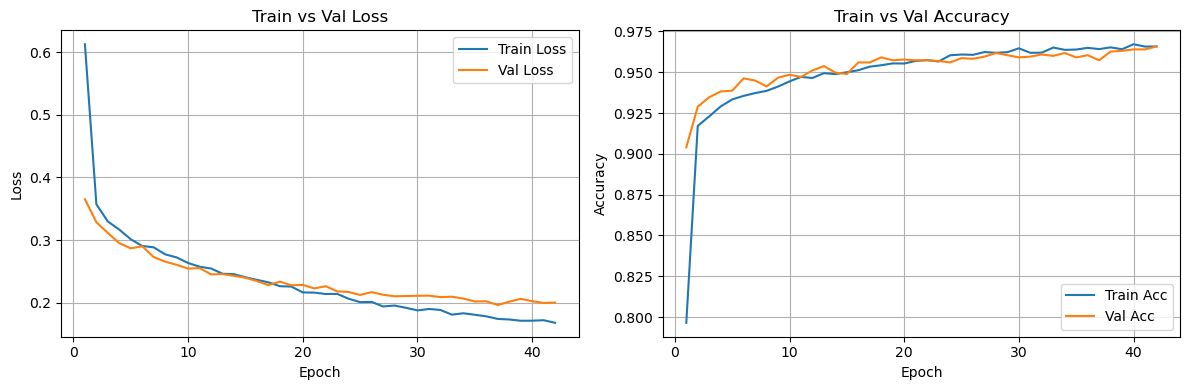

In [11]:
epochs = range(1, len(history["train_loss"]) + 1)

plt.figure(figsize=(12,4))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(epochs, history["train_loss"], label="Train Loss")
plt.plot(epochs, history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Val Loss")
plt.legend()
plt.grid(True)

# Accuracy Curve
plt.subplot(1, 2, 2)
plt.plot(epochs, history["train_acc"], label="Train Acc")
plt.plot(epochs, history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Train vs Val Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [12]:
# Predictions for test set
trained_model.eval()

y_true = []
y_pred = []
y_proba = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        logits = trained_model(X_batch) 
        probs = torch.sigmoid(logits) 
        preds = (probs >= 0.5).float()         

        y_true.extend(y_batch.numpy())
        y_pred.extend(preds.numpy())
        y_proba.extend(probs.numpy())

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_proba = np.array(y_proba)

print("Test Classification Report:")
print(classification_report(y_true, y_pred))

Test Classification Report:
              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97      1715
         1.0       0.90      0.93      0.92       535

    accuracy                           0.96      2250
   macro avg       0.94      0.95      0.94      2250
weighted avg       0.96      0.96      0.96      2250



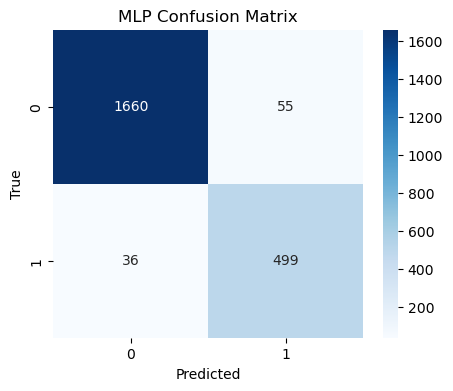

MLP Test AUC: 0.9877834391433475


In [13]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("MLP Confusion Matrix")
plt.show()

fpr, tpr, _ = roc_curve(y_true, y_proba)
roc_auc = auc(fpr, tpr)
print("MLP Test AUC:", roc_auc)